# OLID-BR (EDA)

In this notebook, we will explore the data in the OLID-BR dataset.

In [1]:
import sys
from pathlib import Path

if str(Path(".").absolute().parent) not in sys.path:
    sys.path.append(str(Path(".").absolute().parent.parent))

In [2]:
from dotenv import load_dotenv

# Initialize the env vars
load_dotenv("../../.env")

True

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from src.settings import AppSettings
from src.processing.text import get_toxic_substrings
from src.kaggle import download_dataset

%matplotlib inline

args = AppSettings()

In [42]:
files = download_dataset(
    output_files=[
        "train.csv",
        "train.json",
        "train_metadata.csv"
    ]
)

data = files["train.csv"]

print(f"Shape: {data.shape}")
data.head()

Shape: (4765, 17)


,id,text,is_offensive,is_targeted,targeted_type,toxic_spans,health,ideology,insult,lgbtqphobia,other_lifestyle,physical_aspects,profanity_obscene,racism,religious_intolerance,sexism,xenophobia
0,430b13705cf34e13b74bc999425187c3,USER USER é muito bom. USER ^^ E claro a equip...,NOT,UNT,NaN,NaN,False,False,False,False,False,False,False,False,False,False,False
1,c779826dc43f460cb18e8429ca443477,Pior do que adolescentezinhas de merda...são p...,OFF,UNT,NaN,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,False,True,False,False,False,True,False,False,True,False
2,e64148caa4474fc79298e01d0dda8f5e,USER Toma no cu é vitamina como tu e tua prima.,OFF,TIN,GRP,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",False,False,True,False,False,False,True,False,False,False,False
3,cc66b54eeec24607a67e2259134a1cdd,"Muito bom, pena a circunstâncias serem ruins, ...",OFF,UNT,NaN,"[119, 120, 121, 122, 123, 124, 125, 126, 127, ...",False,False,True,False,False,False,False,False,False,False,False
4,a3d7839456ae4258a70298fcf637952e,"Podia ter beijo também, pra ver se o homofóbic...",OFF,UNT,NaN,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...",False,False,True,False,False,False,False,False,False,False,False


In [5]:
metadata = files["train_metadata.csv"]

print(f"Shape: {metadata.shape}")
metadata.head()

Shape: (19060, 13)


,id,source,created_at,collected_at,toxicity_score,category,annotator_id,gender,year_of_birth,education_level,annotator_type,age,background
0,430b13705cf34e13b74bc999425187c3,YouTube,2011-01-13T18:57:16,2022-04-08T08:03:44.134767,0.8553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,430b13705cf34e13b74bc999425187c3,NaN,NaN,NaN,NaN,NaN,126.0,Male,1997.0,High school,Contract worker,NaN,NaN
2,430b13705cf34e13b74bc999425187c3,NaN,NaN,NaN,NaN,NaN,127.0,Female,1975.0,Master's degree,Contract worker,NaN,NaN
3,430b13705cf34e13b74bc999425187c3,NaN,NaN,NaN,NaN,NaN,128.0,Female,1992.0,Master's degree,Contract worker,NaN,NaN
4,c779826dc43f460cb18e8429ca443477,YouTube,2010-07-19T06:03:21,2022-04-08T08:03:44.134767,0.8785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration

In [6]:
sns.set_theme(style="white")

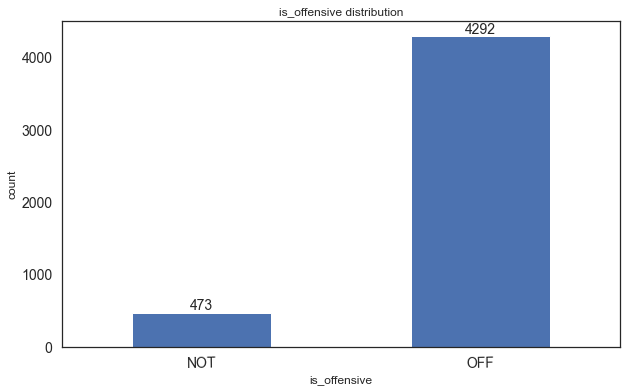

In [7]:
df_temp = data[["text", "is_offensive"]].groupby("is_offensive").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="is_offensive", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="is_offensive", ylabel="count", fontsize=14,
                 rot=1, title="is_offensive distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

In [8]:
def get_toxicity_score(metadata: pd.DataFrame, text_id: str) -> float:
    """Get the toxicity score for a given text_id

    Args:
    - metadata: the metadata dataframe
    - text_id: the text_id
    
    Returns:
    - the toxicity score
    """
    return metadata[(metadata.id == text_id) & (~metadata["toxicity_score"].isnull())].toxicity_score.values[0]

data["toxicity_score"] = data.id.apply(lambda x: get_toxicity_score(metadata, x))

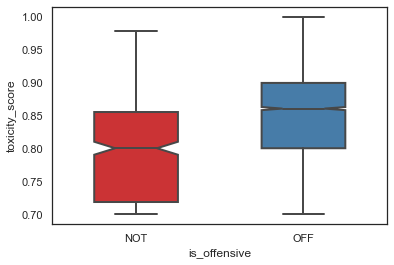

In [9]:
ax = sns.boxplot(x="is_offensive", y="toxicity_score", data=data,
                 palette="Set1", linewidth=2, fliersize=2,
                 width=0.5, showfliers=False, notch=True,
                 whis=1.5, ax=None)

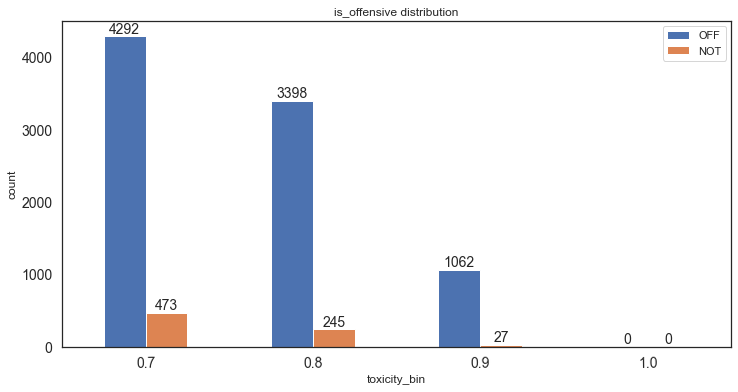

In [10]:
# plot the number of is_offensive per toxicity bin
df_temp = data[["is_offensive", "toxicity_score"]].copy()

df_temp["toxicity_bin"] = df_temp.toxicity_score.apply(lambda x: round(x, 1))
df_temp

# Count the number of is_offensive per toxicity bin
tmp = {}

for bin in df_temp["toxicity_bin"].unique():
    tmp[bin] = {
        "OFF": df_temp[(df_temp["toxicity_score"] >= bin) & (df_temp["is_offensive"] == "OFF")].shape[0],
        "NOT": df_temp[(df_temp["toxicity_score"] >= bin) & (df_temp["is_offensive"] == "NOT")].shape[0]
    }

df_temp = pd.DataFrame(tmp)
df_temp = df_temp.transpose()
df_temp.sort_index(inplace=True)
df_temp.reset_index(inplace=True)
df_temp.rename(columns={"index": "toxicity_bin"}, inplace=True)

ax = df_temp.plot(x="toxicity_bin", kind="bar",
                    legend=True, figsize=(12, 6),
                    xlabel="toxicity_bin", ylabel="count", fontsize=14,
                    rot=1, title="is_offensive distribution")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

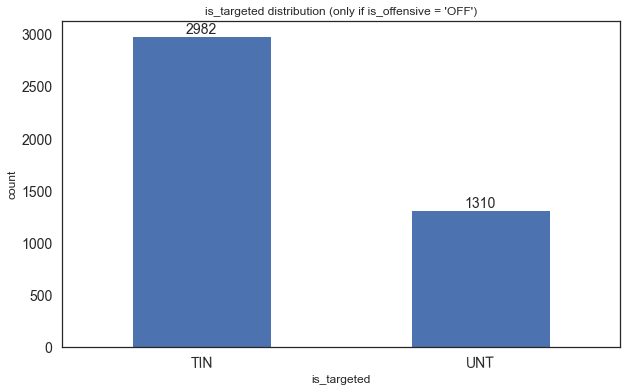

In [11]:
df_temp = data[data["is_offensive"] == "OFF"][["text", "is_targeted"]].groupby("is_targeted").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="is_targeted", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="is_targeted", ylabel="count", fontsize=14,
                 rot=1, title="is_targeted distribution (only if is_offensive = 'OFF')")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

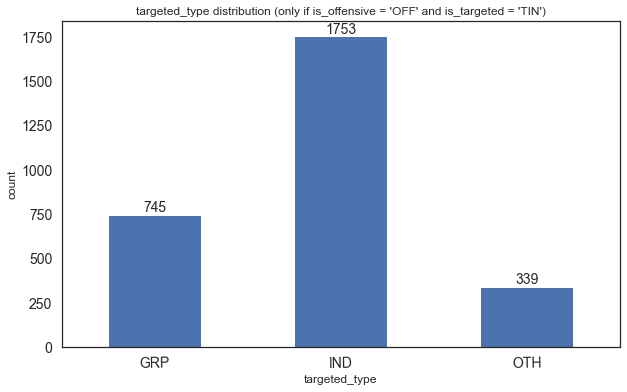

In [12]:
df_temp = data[(data["is_offensive"] == "OFF") & (data["is_targeted"] == "TIN")]
df_temp = df_temp[["text", "targeted_type"]].groupby("targeted_type").count()
df_temp.reset_index(inplace=True)

ax = df_temp.plot(x="targeted_type", kind="bar",
                 legend=False, figsize=(10, 6),
                 xlabel="targeted_type", ylabel="count", fontsize=14,
                 rot=1, title="targeted_type distribution (only if is_offensive = 'OFF' and is_targeted = 'TIN')")

for container in ax.containers:
    ax.bar_label(container, fontsize=14)

## Word Cloud for toxic words

In the next cells, we will generate a word cloud for the toxic words in the dataset.

First, we will get the substrings based on `toxic_spans` field.

Then, we will generate a word cloud for the toxic words.

In [24]:
import ast

def literal_toxic_spans(x):
    if pd.isnull(x) or x == "[]":
        return []
    return ast.literal_eval(x)

data["toxic_spans"] = data["toxic_spans"].apply(literal_toxic_spans)
data["toxic_spans"]

0                                                      []
1       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
2       [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...
3       [119, 120, 121, 122, 123, 124, 125, 126, 127, ...
4       [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...
                              ...                        
4760                                                   []
4761                                                   []
4762             [45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
4763                                                   []
4764                                                   []
Name: toxic_spans, Length: 4765, dtype: object

In [25]:
toxic_substrs = []

for row in data.to_dict(orient="records"):
    if isinstance(row.get("toxic_spans"), list) and len(row.get("toxic_spans")) > 0:
        toxic_substrs.extend(get_toxic_substrings(row["text"], row["toxic_spans"]))
        
print(f"toxic_substrs: {len(toxic_substrs)}")

toxic_substrs: 6424


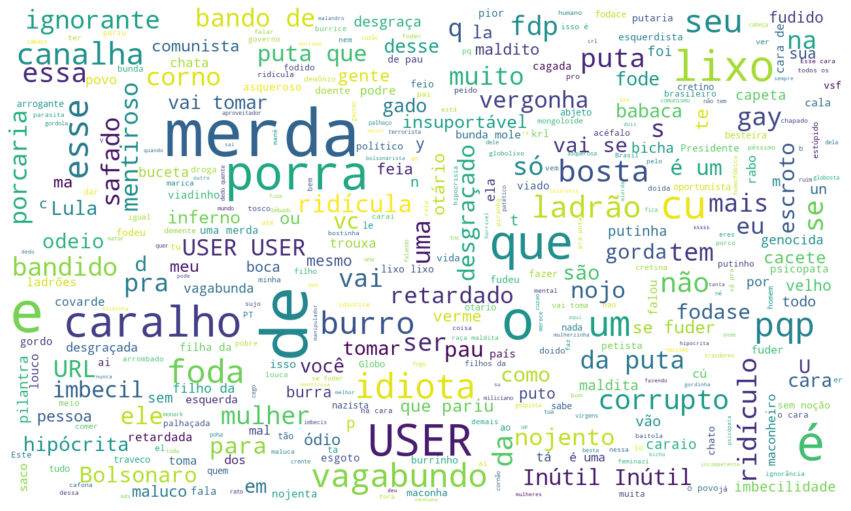

In [33]:
wc = WordCloud(
    width=1280, height=760,
    background_color="white",
    max_words=400, max_font_size=100
)

wc.generate(" ".join(toxic_substrs))

plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()